# Introduction
## Overview
The notebook applies the [SimGAN](https://arxiv.org/pdf/1612.07828v1.pdf) network architecture to the problem of generating realistic images of eyes by using real images to augment the simulated data. We use Keras with a Tensorflow-backend to accomplish the adversarial training. 
### Note 
The model is quite small and the training is tuned down substantially since the limits of Kaggle Kernels and the lack of GPU makes the training very slow

In [1]:
import os
import sys
import keras
from keras import applications
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing import image
import h5py
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

C:\Users\Eric\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\Eric\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warnin

In [2]:
print('tf-version',tf.__version__, 'keras-version', keras.__version__)

tf-version 1.4.0 keras-version 2.1.5


## Loading Data
Here we setup the paths and load the data from the hdf5 files since there would otherwise be too many individual jpg/png images

In [3]:
%matplotlib inline
path = os.path.dirname(os.path.abspath('.'))
data_dir = os.path.join('..', 'input')
cache_dir = '.'

# load the data file and extract dimensions
with h5py.File(os.path.join(data_dir,'gaze.h5'),'r') as t_file:
    print(list(t_file.keys()))
    assert 'image' in t_file, "Images are missing"
    assert 'look_vec' in t_file, "Look vector is missing"
    assert 'path' in t_file, "Paths are missing"
    print('Synthetic images found:',len(t_file['image']))
    for _, (ikey, ival) in zip(range(1), t_file['image'].items()):
        print('image',ikey,'shape:',ival.shape)
        img_height, img_width = ival.shape
        img_channels = 1
    syn_image_stack = np.stack([np.expand_dims(a,-1) for a in t_file['image'].values()],0)

with h5py.File(os.path.join(data_dir,'real_gaze.h5'),'r') as t_file:
    print(list(t_file.keys()))
    assert 'image' in t_file, "Images are missing"
    print('Real Images found:',len(t_file['image']))
    for _, (ikey, ival) in zip(range(1), t_file['image'].items()):
        print('image',ikey,'shape:',ival.shape)
        img_height, img_width = ival.shape
        img_channels = 1
    real_image_stack = np.stack([np.expand_dims(a,-1) for a in t_file['image'].values()],0)

#
# training params
#

nb_steps = 20 # originally 10000, but this makes the kernel time out
batch_size = 49
k_d = 1  # number of discriminator updates per step
k_g = 2  # number of generative network updates per step
log_interval = 100
pre_steps = 15 # for pretraining

['image', 'look_vec', 'path']
Synthetic images found: 50000
image ..\..\..\..\Downloads\UnityEyes_Windows\UnityEyes_Windows\imgs\1.jpg shape: (35, 55)
['image']
Real Images found: 34100
image ..\data\MPIIGaze_Dataset\000055ed-890a-411f-be6e-b8453b495389.png shape: (35, 55)


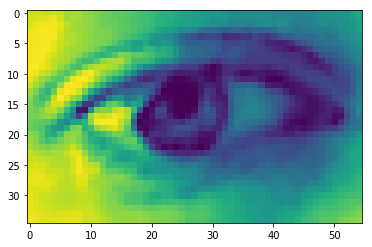

In [4]:
%matplotlib inline
plt.imshow(real_image_stack[1223,:,:,0])
plt.show()

In [5]:
tf.reset_default_graph()

## Utility Functions
These functions make it a bit easier to keep track of how the training is going and make it 

In [6]:
real_image_inputs = real_image_stack[:,:,:,0].reshape(len(real_image_stack),1925)/256
syn_image_inputs = syn_image_stack[:,:,:,0].reshape(len(syn_image_stack),1925)/256

def norm(x):
    return (x-0.5)/0.28

def display_images(images):
    for i in range(images.shape[0]):
        plt.subplot(8, 1, i + 1,figsize=(35, 55))
        plt.imshow(images[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [7]:
n_z = 256
z_test = np.random.uniform(-1.0,1.0,size=[8,n_z])

def display_images(images):
    for i in range(images.shape[0]):
        plt.subplot(1, 8, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

g_learning_rate = 0.00001
d_learning_rate = 0.000001
n_x = 35*55

g_n_layers = 3
d_n_layers = 1
g_n_neurons = [256, 512, 1024]
d_n_neurons = [256]

d_params = {}
g_params = {}

activation = tf.nn.leaky_relu
w_initializer = tf.glorot_uniform_initializer
b_initializer = tf.zeros_initializer

In [8]:
z_p = tf.placeholder(dtype=tf.float32, name='z_p', shape=[None, n_z])
layer = z_p

with tf.variable_scope('g'):
    for i in range(0, g_n_layers):
        w_name = 'w_{0:04d}'.format(i)
        g_params[w_name] = tf.get_variable(
            name=w_name,
            shape=[n_z if i == 0 else g_n_neurons[i - 1], g_n_neurons[i]],
            initializer=w_initializer())

        b_name = 'b_{0:04d}'.format(i)
        g_params[b_name] = tf.get_variable(
            name=b_name, shape=[g_n_neurons[i]], initializer=b_initializer())

        layer = activation(
            tf.matmul(layer, g_params[w_name]) + g_params[b_name])

    #output (logit) layer
    i = g_n_layers
    w_name = 'w_{0:04d}'.format(i)
    g_params[w_name] = tf.get_variable(
        name=w_name,
        shape=[g_n_neurons[i - 1], n_x],
        initializer=w_initializer())

    b_name = 'b_{0:04d}'.format(i)
    g_params[b_name] = tf.get_variable(
        name=b_name, shape=[n_x], initializer=b_initializer())

    g_logit = tf.matmul(layer, g_params[w_name]) + g_params[b_name]
    g_model = tf.nn.tanh(g_logit)

In [9]:
with tf.variable_scope('d'):
    for i in range(0, d_n_layers):
        w_name = 'w_{0:04d}'.format(i)
        d_params[w_name] = tf.get_variable(
            name=w_name,
            shape=[n_x if i == 0 else d_n_neurons[i - 1], d_n_neurons[i]],
            initializer=w_initializer())

        b_name = 'b_{0:04d}'.format(i)
        d_params[b_name] = tf.get_variable(
            name=b_name, shape=[d_n_neurons[i]], initializer=b_initializer())

    #output (logit) layer
    i = d_n_layers
    w_name = 'w_{0:04d}'.format(i)
    d_params[w_name] = tf.get_variable(
        name=w_name, shape=[d_n_neurons[i - 1], 1], initializer=w_initializer())

    b_name = 'b_{0:04d}'.format(i)
    d_params[b_name] = tf.get_variable(
        name=b_name, shape=[1], initializer=b_initializer())

In [10]:
x_p = tf.placeholder(dtype=tf.float32, name='x_p', shape=[None, n_x])

layer = x_p

with tf.variable_scope('d'):
    for i in range(0, d_n_layers):
        w_name = 'w_{0:04d}'.format(i)
        b_name = 'b_{0:04d}'.format(i)

        layer = activation(
            tf.matmul(layer, d_params[w_name]) + d_params[b_name])
        layer = tf.nn.dropout(layer,0.7)
    #output (logit) layer
    i = d_n_layers
    w_name = 'w_{0:04d}'.format(i)
    b_name = 'b_{0:04d}'.format(i)
    d_logit_real = tf.matmul(layer, d_params[w_name]) + d_params[b_name]
    d_model_real = tf.nn.sigmoid(d_logit_real)

In [11]:
z = g_model

layer = z

with tf.variable_scope('d'):
    for i in range(0, d_n_layers):
        w_name = 'w_{0:04d}'.format(i)
        b_name = 'b_{0:04d}'.format(i)

        layer = activation(
            tf.matmul(layer, d_params[w_name]) + d_params[b_name])
        layer = tf.nn.dropout(layer,0.7)
    #output (logit) layer
    i = d_n_layers
    w_name = 'w_{0:04d}'.format(i)
    b_name = 'b_{0:04d}'.format(i)

    d_logit_fake = tf.matmul(layer, d_params[w_name]) + d_params[b_name]
    d_model_fake = tf.nn.sigmoid(d_logit_fake)

In [12]:
g_loss = -tf.reduce_mean(tf.log(d_model_fake))
d_loss = -tf.reduce_mean(tf.log(d_model_real) + tf.log(1 - d_model_fake))
g_loss_summary = tf.summary.scalar('g_loss', g_loss)
d_loss_summary = tf.summary.scalar('d_loss', d_loss)

g_optimizer = tf.train.AdamOptimizer(g_learning_rate)
d_optimizer = tf.train.GradientDescentOptimizer(d_learning_rate)

g_train_op = g_optimizer.minimize(g_loss, var_list=list(g_params.values()))
d_train_op = d_optimizer.minimize(d_loss, var_list=list(d_params.values()))

In [13]:
from datetime import datetime

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

logdir = log_dir("eye_gan")
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

version = '6'
checkpoint_path = "/tmp/eye_gan"+version+".ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./eye_gan"+version

init = tf.global_variables_initializer()
saver = tf.train.Saver()

0
epoch: 0000   d_loss = 4.806268  g_loss = 0.077588


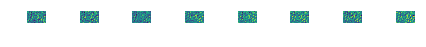

1


In [ ]:
n_epochs = 300
batch_size = 100
n_batches = int(len(real_image_inputs) / batch_size)
best_loss = np.infty
epochs_without_progress = 0
max_epochs_without_progress = 100

n_epochs_print = 5

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)
    
    for epoch in range(n_epochs+1):
        print(epoch)
        epoch_d_loss = 0.0
        epoch_g_loss = 0.0
        for batch in range(n_batches):
            x_batch = real_image_inputs[batch*batch_size:(batch+1)*batch_size,:]
            x_batch = norm(x_batch)
            z_batch = np.random.uniform(-1.0,1.0,size=[batch_size,n_z])
            feed_dict = {x_p: x_batch,z_p: z_batch}
            _,batch_d_loss,d_loss_summary_str = sess.run([d_train_op,d_loss,d_loss_summary], feed_dict=feed_dict)
            file_writer.add_summary(d_loss_summary_str, epoch)
            
            z_batch = np.random.uniform(-1.0,1.0,size=[batch_size,n_z])
            feed_dict={z_p: z_batch}
            _,batch_g_loss,g_loss_summary_str = sess.run([g_train_op,g_loss,g_loss_summary], feed_dict=feed_dict)
            file_writer.add_summary(g_loss_summary_str, epoch)
            
            epoch_d_loss += batch_d_loss 
            epoch_g_loss += batch_g_loss
        saver.save(sess, checkpoint_path)

        if epoch%n_epochs_print == 0:
            average_d_loss = epoch_d_loss / n_batches
            average_g_loss = epoch_g_loss / n_batches
            print('epoch: {0:04d}   d_loss = {1:0.6f}  g_loss = {2:0.6f}'.format(epoch,average_d_loss,average_g_loss))
            x_pred = sess.run(g_model,feed_dict={z_p:z_test})
            display_images(x_pred.reshape(-1,35,55))

            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))
            if batch_g_loss < best_loss:
                saver.save(sess, final_model_path)
                best_loss = batch_g_loss
            else:
                epochs_without_progress += n_epochs_print
            if epochs_without_progress > max_epochs_without_progress:
                print("Early stopping")
                break